In [228]:
import pandas as pd
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer
from gensim import models, corpora
import nltk
from nltk.corpus import stopwords 
nltk.download("stopwords")
import string
from typing import List

[nltk_data] Downloading package stopwords to /Users/anton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [229]:
einreichungen_df = pd.read_csv("uberdrivers_submissions_output_unfiltered_scores_time.csv")
kommentare_df = pd.read_csv("uberdrivers_comments_output_unfiltered_scores_time.csv")

In [230]:
#CLEANING
import string
import re 
import unidecode 

def convert_to_lowercase(text: str) -> str:
    return text.lower()

def regex(text: str) -> str:
    text = re.sub(r'https?://[^\s]+', '', text)
    text = re.sub(r'\S*@\S*\s?', '', text) #EMAIL
    text = re.sub(r'\s+', ' ', text) #Mehrface sapces zu einem
    text = re.sub(r"\'", '', text)#Anführungszeichen 
    text = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', '', text) #SMILEYS
    text = re.sub(r'\d+', '', text) #Zahlen
    text = re.sub(r'\b\w\b', '', text) #Einzelne buchstaben  
    hashtags = re.findall(r'#\w+', text) #Hashtags in hashtags
    text += ' '.join(hashtags)   #hastags in text 
    return text

def remove_punctuation(text: str, punct: str = string.punctuation) -> str:  
    cleaned_text = "".join([char for char in text if char not in punct])
    return cleaned_text

def unicode(text: str) -> str:
    return unidecode.unidecode(text)

def remove_stopwords(text: str, sw: List[str] = stopwords.words("english")) -> str:   
    additional_sw = ["dont", "get", "im", "ive", "uber", "ubers", "driver", "drivers", "drive", "doesnt", "ampnbsp", ]
    sw = sw + additional_sw
    text_list = text.split()
    text_list = [word for word in text_list if word not in sw]
    return " ".join(text_list)

def clean(text: str) -> str:
    text = unicode(text)
    text = remove_punctuation(text)
    text = convert_to_lowercase(text)
    text = remove_stopwords(text)
    text = regex(text)
    return text


In [231]:
kommentare_df = kommentare_df[kommentare_df['body'] != "[deleted]"]

kommentare_df["body"] = kommentare_df["body"].astype(str).apply(lambda x : clean(x))
einreichungen_df["title"] = einreichungen_df["title"].astype(str).apply(lambda x : clean(x))
einreichungen_df["selftext"] = einreichungen_df["selftext"].astype(str).apply(lambda x : clean(x))

einreichungen_df["selftext"] = einreichungen_df["selftext"].replace('nan', '')
einreichungen_df["selftext"] = einreichungen_df["selftext"].replace('deleted', '')
einreichungen_df["selftext"] = einreichungen_df["selftext"].replace('removed', '')

einreichungen_df["title"] = einreichungen_df["title"].replace('deleted', '')
einreichungen_df["title"] = einreichungen_df["title"].replace('removed', '')
einreichungen_df = einreichungen_df[einreichungen_df['title'] != 'deleted by user']

einreichungen_df = einreichungen_df[~(((einreichungen_df['title'].str.split().apply(len) <= 1) & (einreichungen_df['selftext'].str.split().apply(len) <= 1)))]

kommentare_df = kommentare_df[kommentare_df['body'].str.split().apply(len) > 1].copy()

einreichungen_df.to_csv("clean_selftext_.csv")
einreichungen_df.head()

,selftext,title,author,score,created_utc
0,ask anything happy answer regarding driving ex...,iama uberx ama,Deucer22,3,1383634692
1,,anyone want uberx,[deleted],2,1383634579
2,anyone else got good stories weekend saw lady ...,interesting stories weekend,Deucer22,1,1384163796
3,first negative uberx experience last weekend p...,first bad experience uberx,Raydr,7,1384299072
4,free uberx week starting dallas monday id like...,jacksonville uberx,Raydr,3,1384382869


In [232]:
kommentare_df.head()

,body,author,score,created_utc
0,got accepted sending paperwork really question...,im_usually_right,2,1383683430
2,sorry delayed response havent trouble problem ...,Deucer22,2,1383844809
3,driving uberx months done around total rides,Deucer22,1,1383844894
4,started driving week wondering went ur way pp...,AviAdi,2,1383845731
5,insurance issue definitely biggest gray area s...,Deucer22,2,1383846475


In [233]:
print("Anzahl der Kommentare:", len(kommentare_df))
print("Anzahl der Beiträge:", len(einreichungen_df))

Anzahl der Kommentare: 1393805
Anzahl der Beiträge: 112957


In [235]:
einreichungen_df['created_utc'] = pd.to_datetime(einreichungen_df['created_utc'], unit='s')
kommentare_df['created_utc'] = pd.to_datetime(kommentare_df['created_utc'], unit='s')

In [236]:

kommentare_df['created_utc'] = pd.to_datetime(kommentare_df['created_utc'], unit='s')

# Zeitlich erster Kommentar
erster_kommentar = kommentare_df.loc[kommentare_df['created_utc'].idxmin()]
print("Zeitlich erster Kommentar:")
print(erster_kommentar)

# Zeitlich letzter Kommentar
letzter_kommentar = kommentare_df.loc[kommentare_df['created_utc'].idxmax()]
print("\nZeitlich letzter Kommentar:")
print(letzter_kommentar)


Zeitlich erster Kommentar:
body           got accepted sending paperwork really question...
author                                          im_usually_right
score                                                          2
created_utc                                  2013-11-05 20:30:30
Name: 0, dtype: object

Zeitlich letzter Kommentar:
body                  ones duty ha
author                  maximagent
score                            2
created_utc    2022-12-31 23:57:41
Name: 1571270, dtype: object


In [237]:

einreichungen_df['created_utc'] = pd.to_datetime(einreichungen_df['created_utc'], unit='s')

# Zeitlich erster Beitrag
erster_beitrag = einreichungen_df.loc[einreichungen_df['created_utc'].idxmin()]
print("Zeitlich erster Beitrag:")
print(erster_beitrag)

# Zeitlich letzter Beitrag
letzter_beitrag = einreichungen_df.loc[einreichungen_df['created_utc'].idxmax()]
print("\nZeitlich letzter Beitrag:")
print(letzter_beitrag)

Zeitlich erster Beitrag:
selftext                          
title            anyone want uberx
author                   [deleted]
score                            2
created_utc    2013-11-05 06:56:19
Name: 1, dtype: object

Zeitlich letzter Beitrag:
selftext                          
title             training working
author                    psychiea
score                            1
created_utc    2022-12-31 23:58:55
Name: 116545, dtype: object


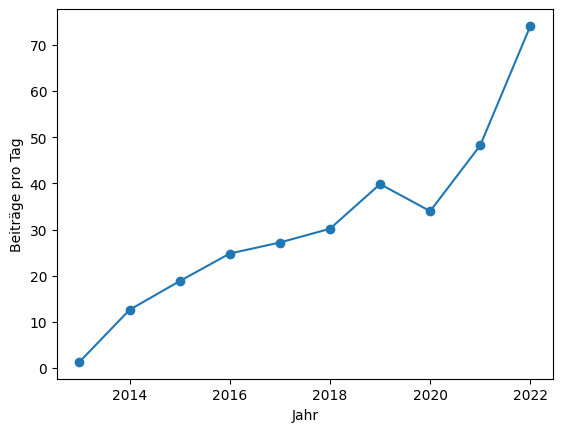

In [238]:
import matplotlib.pyplot as plt


einreichungen_df['year'] = einreichungen_df['created_utc'].dt.year

jahre_zur_betrachtung = range(2013, 2023)  # 2013 bis 2022

einreichungen_df_filtered = einreichungen_df[einreichungen_df['year'].isin(jahre_zur_betrachtung)]

# Aggregieren der Beiträge pro Tag und Jahr
beitraege_pro_tag_pro_jahr = einreichungen_df_filtered.groupby([einreichungen_df_filtered['created_utc'].dt.date, einreichungen_df_filtered['year']])['title'].count().reset_index()

# Durchschnittliche Beiträge pro Tag für jedes Jahr
durchschnitt_beitraege_pro_tag = beitraege_pro_tag_pro_jahr.groupby('year')['title'].mean()

# Plot der durchschnittlichen Beiträge pro Tag
plt.plot(durchschnitt_beitraege_pro_tag.index, durchschnitt_beitraege_pro_tag.values, marker='o')
plt.xlabel('Jahr')
plt.ylabel('Beiträge pro Tag')
plt.savefig("Submissions_per_day_per_year_final2.png")
plt.show()

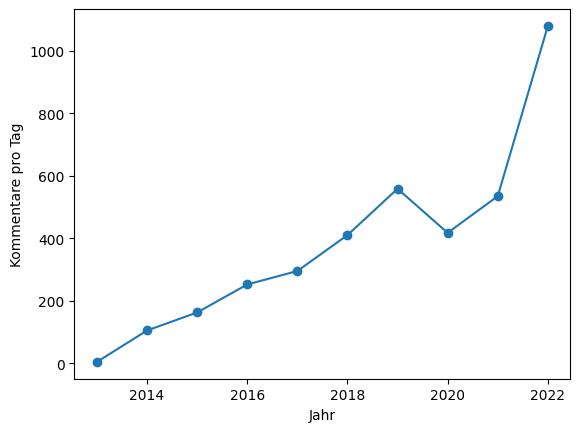

In [239]:
kommentare_df['year'] = kommentare_df['created_utc'].dt.year

# Filtern der Daten für den Zeitraum von 2013 bis 2022 für Kommentare
jahre_zur_betrachtung = range(2013, 2023)  # 2013 bis 2022

kommentare_df_filtered = kommentare_df[kommentare_df['year'].isin(jahre_zur_betrachtung)]

# Aggregieren der Kommentare pro Tag und Jahr
kommentare_pro_tag_pro_jahr = kommentare_df_filtered.groupby([kommentare_df_filtered['created_utc'].dt.date, kommentare_df_filtered['year']]).size().reset_index(name='Anzahl')

# Durchschnittliche Kommentare pro Tag für jedes Jahr
durchschnitt_kommentare_pro_tag = kommentare_pro_tag_pro_jahr.groupby('year')['Anzahl'].mean()

# Plot der durchschnittlichen Kommentare pro Tag
plt.plot(durchschnitt_kommentare_pro_tag.index, durchschnitt_kommentare_pro_tag.values, marker='o')
plt.xlabel('Jahr')
plt.ylabel('Kommentare pro Tag')
plt.savefig("comments_per_day_per_day_final2.png")
plt.show()

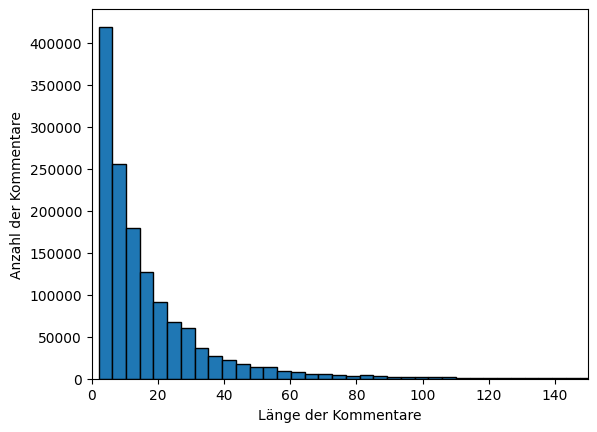

In [240]:
import matplotlib.pyplot as plt

# Berechnung der Länge der Kommentare
kommentare_df['comment_length'] = kommentare_df['body'].str.split().apply(len)

# Plot des detaillierteren Histogramms der Kommentarlängen
plt.hist(kommentare_df['comment_length'], bins=300, edgecolor='black')
plt.xlabel('Länge der Kommentare')
plt.ylabel('Anzahl der Kommentare')

# Festlegung des gewünschten Bereichs für die X-Achse
plt.xlim(0, 150)  # Anpassen Sie die Werte nach Bedarf
plt.savefig("laenge_kommentare_final2.png")
plt.show()

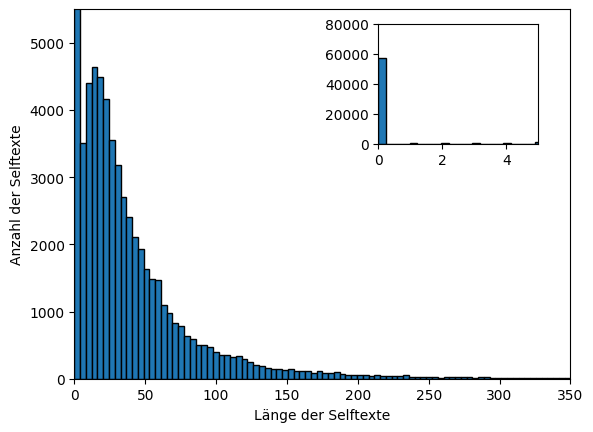

In [241]:
einreichungen_df['selftext_length'] = einreichungen_df['selftext'].str.split().apply(len)

# Plot des detaillierten Histogramms der Selftextlängen
plt.hist(einreichungen_df['selftext_length'], bins=600, edgecolor='black')
plt.xlabel('Länge der Selftexte')
plt.ylabel('Anzahl der Selftexte')

# Festlegung des gesamten Bereichs für die X-Achse
plt.xlim(0, 350)  # Anpassen Sie die Werte nach Bedarf
plt.ylim(0,5500)

ax_zoom = plt.axes([0.6, 0.6, 0.25, 0.25])
ax_zoom.hist(einreichungen_df['selftext_length'], bins=10000, edgecolor='black')
ax_zoom.set_xlim(0, 5)
ax_zoom.set_ylim(0, 80000)

plt.savefig("laenge_selftext_final2.png")
plt.show()


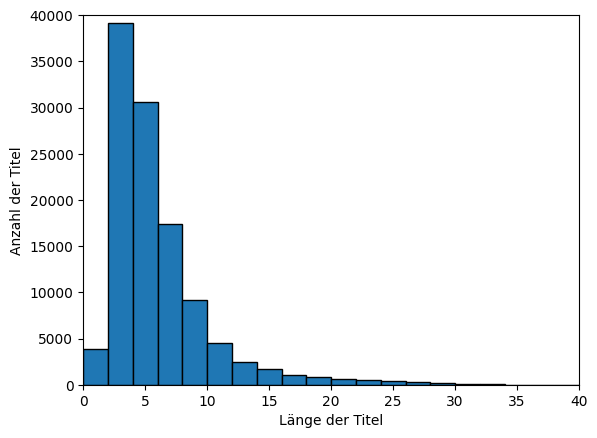

In [242]:
einreichungen_df['title_length'] = einreichungen_df['title'].str.split().apply(len)

# Plot des detaillierten Histogramms der Selftextlängen
plt.hist(einreichungen_df['title_length'], bins=20, edgecolor='black')
plt.xlabel('Länge der Titel')
plt.ylabel('Anzahl der Titel')

# Festlegung des gesamten Bereichs für die X-Achse
plt.xlim(0, 40)  # Anpassen Sie die Werte nach Bedarf
plt.ylim(0,40000)
plt.savefig("laenge_titel_final2.png")
plt.show()

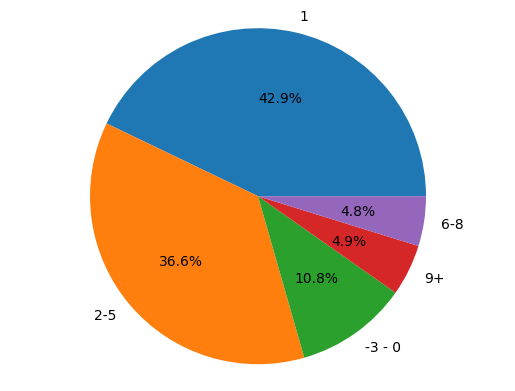

In [243]:
import matplotlib.pyplot as plt

# Daten für das Tortendiagramm
kommentare_scores = kommentare_df['score']

# Aggregierte Werte für das Tortendiagramm
score_groups = pd.cut(kommentare_scores, bins=[-float('inf'), 0, 1, 5, 8, float('inf')], labels=['-3 - 0', "1", '2-5', '6-8', '9+'])
score_counts = score_groups.value_counts()

# Begrenzung auf maximal 10 Teile
max_parts = 10
if len(score_counts) > max_parts:
    other_count = score_counts[max_parts:].sum()
    score_counts = score_counts[:max_parts]
    score_counts[max_parts] = other_count

# Plot des Tortendiagramms der gruppierten Kommentar-Scores
plt.pie(score_counts, labels=score_counts.index, autopct='%1.1f%%')

plt.axis('equal')
plt.savefig("Verteilung_scores_kommentare_final2.png")

plt.show()


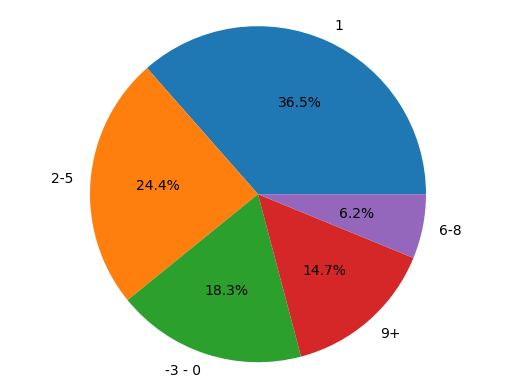

In [244]:
import matplotlib.pyplot as plt

# Daten für das Tortendiagramm
beitraege_scores = einreichungen_df['score']

# Aggregierte Werte für das Tortendiagramm
score_groups = pd.cut(beitraege_scores, bins=[-float('inf'), 0, 1, 5, 8, float('inf')], labels=['-3 - 0', "1", '2-5', '6-8', '9+'])
score_counts = score_groups.value_counts()

# Begrenzung auf maximal 10 Teile
max_parts = 10
if len(score_counts) > max_parts:
    other_count = score_counts[max_parts:].sum()
    score_counts = score_counts[:max_parts]
    score_counts[max_parts] = other_count

# Plot des Tortendiagramms der gruppierten Beitrags-Scores
plt.pie(score_counts, labels=score_counts.index, autopct='%1.1f%%')

plt.axis('equal')
plt.savefig("Verteilung_scores_Beitrag_final2.png")

plt.show()


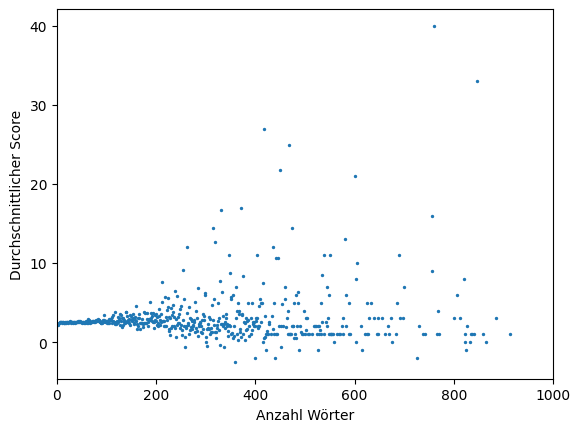

In [245]:
# Gruppieren der Daten nach der Anzahl der Wörter und Berechnung des Durchschnitts des Scores
grouped_df = kommentare_df.groupby('comment_length')['score'].mean().reset_index()

# Scatterplot mit dem Durchschnittsscore über die Anzahl der Wörter
plt.scatter(grouped_df["comment_length"], grouped_df["score"], s=2)
plt.xlabel('Anzahl Wörter')
plt.ylabel('Durchschnittlicher Score')
plt.xlim(0, 1000)
plt.savefig("selftext_length_score.png")
plt.show()


In [246]:
print(kommentare_df['body'].str.split().apply(len).mean())
print(einreichungen_df['selftext'].str.split().apply(len).mean())
print(einreichungen_df['title'].str.split().apply(len).mean())

17.676113947072942
22.524314562178528
5.4160432731039245


In [247]:
new_df = einreichungen_df[(einreichungen_df['title'].str.split().apply(len) == 4) & einreichungen_df["selftext"].str.split().apply(len)==7]
new_df.to_csv("check.csv")
new_df.head()

,selftext,title,author,score,created_utc,year,selftext_length,title_length


In [248]:
selftext_liste = einreichungen_df["selftext"].tolist()
title_liste = einreichungen_df["title"].tolist()
comment_liste = kommentare_df["body"].tolist()
all_liste = title_liste + comment_liste + selftext_liste

In [249]:
def get_bigram_counts(liste):
  
    bigram_list = []
    

    for satz in liste:

        bigram_satz = list(ngrams(satz.split(), 2))
        

        bigram_list.extend(bigram_satz)
    

    bigram_counts = Counter(bigram_list)

    top_10_bigrams = bigram_counts.most_common(30)
    

    df = pd.DataFrame(top_10_bigrams, columns=['Bigram', 'Häufigkeit'])
    
    return df

In [250]:
def get_trigram_counts(liste):

    trigram_list = []
    

    for satz in liste:

        trigram_satz = list(ngrams(satz.split(), 3))
        

        trigram_list.extend(trigram_satz)
    

    trigram_counts = Counter(trigram_list)

    top_15_trigrams = trigram_counts.most_common(30)
    

    df = pd.DataFrame(top_15_trigrams, columns=['Trigram', 'Häufigkeit'])
    
    return df

In [251]:
def get_unigram_counts(liste):
    
    unigram_list = [wort for satz in liste for wort in satz.split()]
    
 
    unigram_counts = Counter(unigram_list)
    top_15_unigrams = unigram_counts.most_common(30)
 
    df = pd.DataFrame(top_15_unigrams, columns=['Unigram', 'Häufigkeit'])
    
    return df

In [252]:
import pandas as pd
from nltk import ngrams
from collections import Counter
df1 = get_unigram_counts(all_liste)
df2 = get_bigram_counts(all_liste)
df3 = get_trigram_counts(all_liste)


In [253]:
df_all = pd.concat([df1, df2, df3], axis=1, ignore_index=False, join='outer')
df_all.to_csv("all_n_grams.csv")

In [254]:
print(df1)
print(df2)
print(df3)

    Unigram  Häufigkeit
0      like      227027
1      time      181746
2       car      180107
3    people      170720
4     would      169541
5       one      165689
6      ride      150210
7      make      131965
8      know      129228
9        go      112923
10     even      112506
11    youre      111032
12    thats      110272
13  driving      107435
14      got      105787
15    going      102129
16      pax      101509
17    rides      100425
18     take       99800
19     back       99435
20    think       99314
21      way       96321
22     good       95479
23      app       92415
24     want       91100
25     also       90327
26      see       89715
27    money       87970
28      pay       85102
29    never       80660
                 Bigram  Häufigkeit
0          (full, time)       12233
1          (make, sure)       12110
2         (make, money)       11321
3           (per, mile)       11050
4         (last, night)        9728
5        (sounds, like)        9055
6   

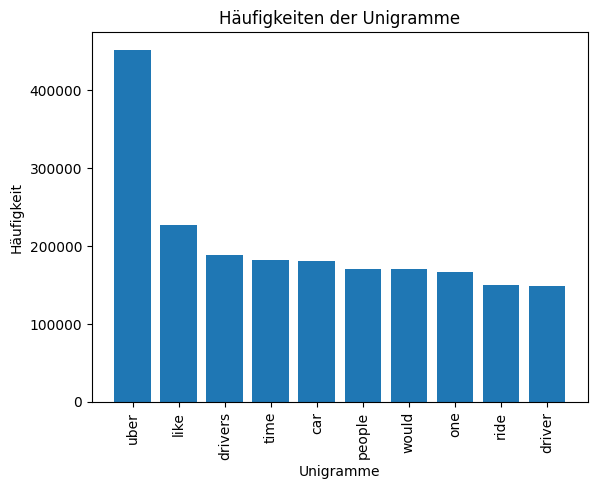

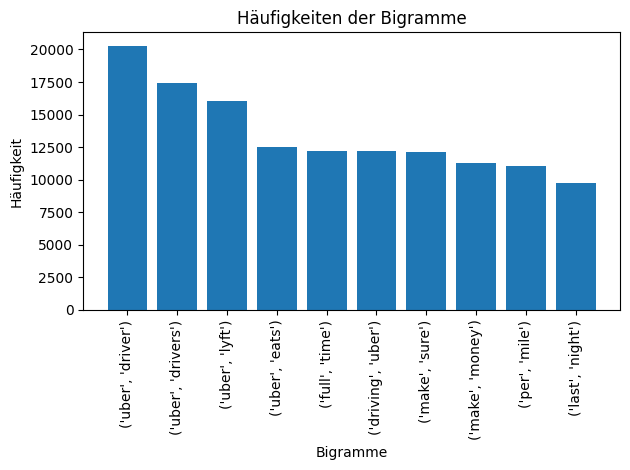

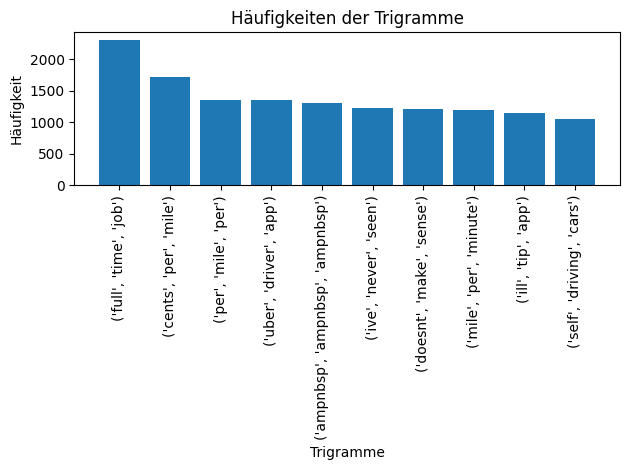

In [255]:
import matplotlib.pyplot as plt

# Daten für die Beispieldaten
unigramme = ['uber', 'like', 'drivers', 'time', 'car', 'people', 'would', 'one', 'ride', 'driver']
h_unigramme = [451778, 227046, 187693, 181758, 180123, 170725, 169550, 165697, 150212, 148935]

bigramme = [('uber', 'driver'), ('uber', 'drivers'), ('uber', 'lyft'), ('uber', 'eats'), ('full', 'time'), ('driving', 'uber'), ('make', 'sure'), ('make', 'money'), ('per', 'mile'), ('last', 'night')]
h_bigramme = [20300, 17434, 16029, 12518, 12231, 12171, 12108, 11253, 11048, 9721]

trigramme = [('full', 'time', 'job'), ('cents', 'per', 'mile'), ('per', 'mile', 'per'), ('uber', 'driver', 'app'), ('ampnbsp', 'ampnbsp', 'ampnbsp'), ('ive', 'never', 'seen'), ('doesnt', 'make', 'sense'), ('mile', 'per', 'minute'), ('ill', 'tip', 'app'), ('self', 'driving', 'cars')]
h_trigramme = [2308, 1717, 1351, 1350, 1297, 1220, 1201, 1191, 1143, 1051]

# Unigramm-Barchart
plt.bar(unigramme, h_unigramme)
plt.xlabel('Unigramme')
plt.ylabel('Häufigkeit')
plt.title('Häufigkeiten der Unigramme')
plt.xticks(rotation=90)
plt.savefig("unigrams.png")
plt.show()

# Bigramm-Barchart
plt.bar(range(len(bigramme)), h_bigramme)
plt.xlabel('Bigramme')
plt.ylabel('Häufigkeit')
plt.title('Häufigkeiten der Bigramme')
plt.xticks(range(len(bigramme)), bigramme, rotation=90)
plt.tight_layout()
plt.savefig("bigrams.png")
plt.show()

# Trigramm-Barchart
plt.bar(range(len(trigramme)), h_trigramme)
plt.xlabel('Trigramme')
plt.ylabel('Häufigkeit')
plt.title('Häufigkeiten der Trigramme')
plt.xticks(range(len(trigramme)), trigramme, rotation=90)
plt.tight_layout()
plt.savefig("trigrams.png")
plt.show()


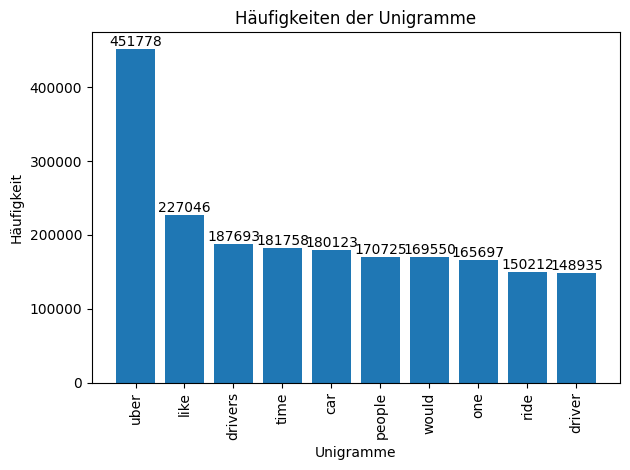

In [256]:
import matplotlib.pyplot as plt

# Daten für die Beispieldaten
unigramme = ['uber', 'like', 'drivers', 'time', 'car', 'people', 'would', 'one', 'ride', 'driver']
h_unigramme = [451778, 227046, 187693, 181758, 180123, 170725, 169550, 165697, 150212, 148935]

# Unigramm-Barchart
plt.bar(unigramme, h_unigramme)
plt.xlabel('Unigramme')
plt.ylabel('Häufigkeit')
plt.title('Häufigkeiten der Unigramme')

# Beschriftungen in den Balken platzieren
for i in range(len(unigramme)):
    plt.text(i, h_unigramme[i], str(h_unigramme[i]), ha='center', va='bottom')

plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.show()

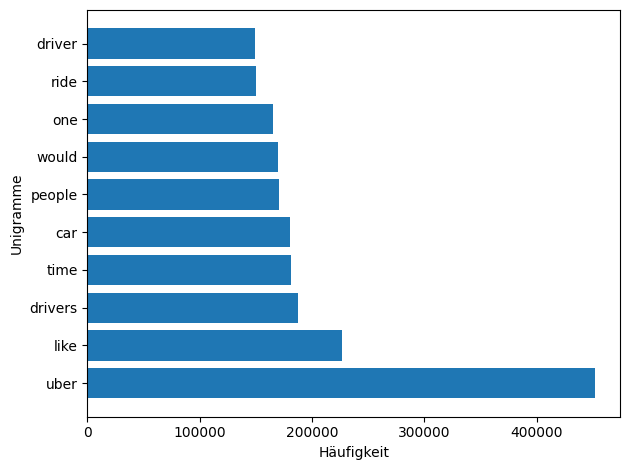

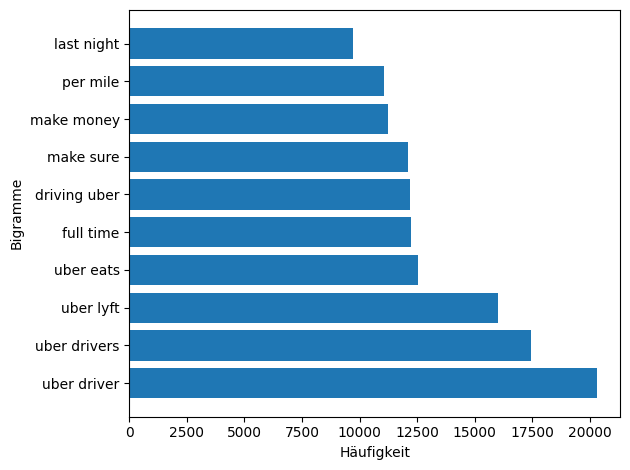

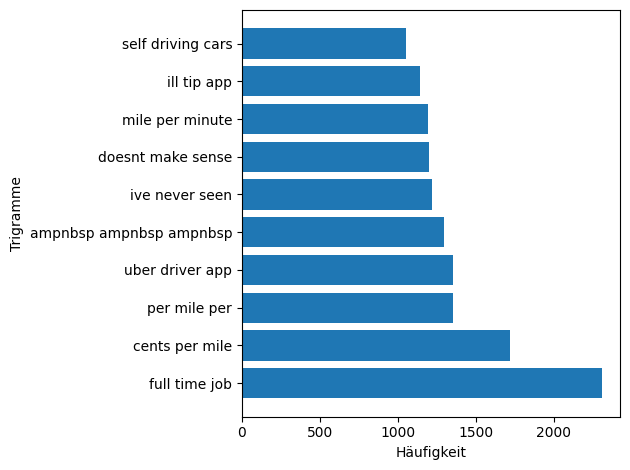

In [257]:
import matplotlib.pyplot as plt

# Daten für die Beispieldaten
unigramme = ['uber', 'like', 'drivers', 'time', 'car', 'people', 'would', 'one', 'ride', 'driver']
h_unigramme = [451778, 227046, 187693, 181758, 180123, 170725, 169550, 165697, 150212, 148935]

bigramme = [('uber driver'), ('uber drivers'), ('uber lyft'), ('uber eats'), ('full time'), ('driving uber'), ('make sure'), ('make money'), ('per mile'), ('last night')]
h_bigramme = [20300, 17434, 16029, 12518, 12231, 12171, 12108, 11253, 11048, 9721]

trigramme = [('full time job'), ('cents per mile'), ('per mile per'), ('uber driver app'), ('ampnbsp ampnbsp ampnbsp'), ('ive never seen'), ('doesnt make sense'), ('mile per minute'), ('ill tip app'), ('self driving cars')]
h_trigramme = [2308, 1717, 1351, 1350, 1297, 1220, 1201, 1191, 1143, 1051]

# Unigramm-Barchart
plt.barh(range(len(unigramme)), h_unigramme)
plt.ylabel('Unigramme')
plt.xlabel('Häufigkeit')


plt.yticks(range(len(unigramme)), unigramme)
plt.tight_layout()
plt.savefig("unigrams_final.png")
plt.show()

# Bigramm-Barchart
plt.barh(range(len(bigramme)), h_bigramme)
plt.ylabel('Bigramme')
plt.xlabel('Häufigkeit')


plt.yticks(range(len(bigramme)), bigramme)
plt.tight_layout()
plt.savefig("bigrams_final.png")
plt.show()

# Trigramm-Barchart
plt.barh(range(len(trigramme)), h_trigramme)
plt.ylabel('Trigramme')
plt.xlabel('Häufigkeit')


plt.yticks(range(len(trigramme)), trigramme)
plt.tight_layout()
plt.savefig("trigrams_final.png")
plt.show()
